# **Notebook Objective**

**Description:**
The objective of this notebook is to train and evaluate regression models
to predict the burden of disease (DALYs) based on PM₂.₅ exposure,
socio-demographic development, and the engineered features. We will
train two types of models—Linear Regression and Random Forest—for each
of the four target DALY outcomes. The performance of these models will
be evaluated, and the best-performing models (Random Forests) will be
saved as artifacts for further analysis.

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import joblib  # For saving/loading models
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define file paths
input_file = Path("../pm25_health_impact_analysis/0_datasets/analysis_ready_data.csv")
model_dir = Path("../pm25_health_impact_analysis/5_model_artifacts/")
metrics_file = Path(
    "../pm25_health_impact_analysis/5_model_artifacts/model_performance_scores.csv"
)
figure_dir = Path("../pm25_health_impact_analysis/figures/model_diagnostics/")

# Ensure the output directories exist
model_dir.mkdir(parents=True, exist_ok=True)
figure_dir.mkdir(parents=True, exist_ok=True)

# Set plotting style
sns.set_theme(style="whitegrid")

### **Load and Prepare Data for Modeling**

**Description:**
This cell loads the `analysis_ready_data.csv` and prepares it for
modeling. We define our predictor (independent) and target (dependent)
variables. A final modeling DataFrame is created by dropping any rows
that have missing values in the selected columns, which is a necessary
step as regression models cannot handle `NaN` inputs.

In [15]:
# Load the analysis-ready dataset
try:
    df = pd.read_csv(input_file)
    print(f"Successfully loaded data from: {input_file}")
except FileNotFoundError:
    print(f"Error: The file {input_file} was not found.")
    print("Please run '01_data_quality_prep.ipynb' first.")
    print("Then run '02_exploratory_trends.ipynb'.")

# Define predictor and target variables
predictor_vars = [
    "PM2.5",
    "SDI",
    "PM25_lag1",
    "PM25_lag2",
    "PM25_3yr_avg",
    "PM25_5yr_avg",
    "PM25_SDI_interaction",
]

target_vars = [
    "All-cause DALYs",
    "Cardiovascular DALYs",
    "Stroke DALYs",
    "Respiratory DALYs",
]

# Create the final modeling dataframe by dropping NaNs
all_model_vars = predictor_vars + target_vars
model_df = df[all_model_vars].dropna().reset_index(drop=True)

print(f"\nOriginal DataFrame shape: {df.shape}")
print(f"Shape after dropping NaNs for modeling: {model_df.shape}")
print(f"Number of rows dropped: {df.shape[0] - model_df.shape[0]}")

# Separate features (X) and create a dictionary of targets (y)
X = model_df[predictor_vars]
y_dict = {target: model_df[target] for target in target_vars}

# Display the first few rows of the feature matrix to verify
print("\nFeature matrix (X) for modeling:")
display(X.head())

Successfully loaded data from: ..\pm25_health_impact_analysis\0_datasets\analysis_ready_data.csv

Original DataFrame shape: (1950, 14)
Shape after dropping NaNs for modeling: (1560, 11)
Number of rows dropped: 390

Feature matrix (X) for modeling:


,PM2.5,SDI,PM25_lag1,PM25_lag2,PM25_3yr_avg,PM25_5yr_avg,PM25_SDI_interaction
0,68.26,0.266484,66.94,68.97,68.056667,68.056667,18.190226
1,72.18,0.275637,68.26,66.94,69.126667,69.087500,19.895447
2,68.06,0.284030,72.18,68.26,69.500000,68.882000,19.331106
3,67.20,0.291850,68.06,72.18,69.146667,68.528000,19.612287
4,64.00,0.299631,67.20,68.06,66.420000,67.940000,19.176365


### **Train, Evaluate, and Save Models**

**Description:**
This is the core modeling cell. It iterates through each of the four DALY
outcomes. For each outcome, it performs the following actions:

1. Splits the data into training (80%) and testing (20%) sets.
2. Trains both a Linear Regression and a Random Forest Regressor model.
3. Evaluates each model's performance on the test set using R-squared
   (R²) and Root Mean Squared Error (RMSE).
4. Saves the trained Random Forest model to a `.pkl` file in the
   `5_model_artifacts` directory for later use.
5. Stores the performance metrics in a dictionary for summary reporting.

In [16]:
# Initialize dictionaries to store results and trained models
model_results = {}
trained_models = {}

# Loop through each target variable to train and evaluate models
for target_name, y in y_dict.items():
    print(f"\n--- Modeling for: {target_name} ---")

    # 1. Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 2. Define models to train
    models_to_train = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(
            n_estimators=100, random_state=42, n_jobs=-1
        ),
    }

    # Initialize nested dictionaries
    model_results[target_name] = {}
    trained_models[target_name] = {}

    for model_name, model in models_to_train.items():
        # 3. Train the model
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)

        # 4. Make predictions and evaluate
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # 5. Store results and the trained model instance
        model_results[target_name][model_name] = {"R²": r2, "RMSE": rmse}
        trained_models[target_name][model_name] = model
        print(f"  {model_name} -> R²: {r2:.4f}, RMSE: {rmse:.4f}")

    # 6. Save the best model (Random Forest) to a file
    rf_model_to_save = trained_models[target_name]["Random Forest"]
    model_filename = model_dir / (
        f"rf_model_{target_name.replace(' ', '_').lower()}.pkl"
    )
    joblib.dump(rf_model_to_save, model_filename)
    print(f"  Saved Random Forest model to: {model_filename}")

print("\n--- Model training and saving complete. ---")


--- Modeling for: All-cause DALYs ---
Training Linear Regression...
  Linear Regression -> R²: 0.4863, RMSE: 646.6781
Training Random Forest...
  Random Forest -> R²: 0.7883, RMSE: 415.1416
  Saved Random Forest model to: ..\pm25_health_impact_analysis\5_model_artifacts\rf_model_all-cause_dalys.pkl

--- Modeling for: Cardiovascular DALYs ---
Training Linear Regression...
  Linear Regression -> R²: 0.4598, RMSE: 460.6271
Training Random Forest...
  Random Forest -> R²: 0.7910, RMSE: 286.4897
  Saved Random Forest model to: ..\pm25_health_impact_analysis\5_model_artifacts\rf_model_cardiovascular_dalys.pkl

--- Modeling for: Stroke DALYs ---
Training Linear Regression...
  Linear Regression -> R²: 0.4592, RMSE: 149.2854
Training Random Forest...
  Random Forest -> R²: 0.7359, RMSE: 104.3176
  Saved Random Forest model to: ..\pm25_health_impact_analysis\5_model_artifacts\rf_model_stroke_dalys.pkl

--- Modeling for: Respiratory DALYs ---
Training Linear Regression...
  Linear Regression ->

### **Compile and Save Performance Metrics**

**Description:**
This cell takes the performance metrics collected in the previous step,
compiles them into a clean and readable pandas DataFrame, and saves this
summary table to a CSV file. This creates a persistent record of the
model performance.

In [17]:
# Create a DataFrame from the nested dictionary of results
results_df = pd.DataFrame.from_dict(
    {
        (i, j): model_results[i][j]
        for i in model_results.keys()
        for j in model_results[i].keys()
    },
    orient="index",
)
results_df.index.names = ["DALY Outcome", "Model"]

print("--- Summary of Model Performance ---")
display(results_df)

# Ensure the metrics directory exists -again-
metrics_file.parent.mkdir(parents=True, exist_ok=True)

# Save the results DataFrame to a CSV file
try:
    results_df.to_csv(metrics_file)
    print(f"\nSuccessfully saved model performance metrics to: {metrics_file}")
except Exception as e:
    print(f"An error occurred while saving the metrics file: {e}")

--- Summary of Model Performance ---


R²        RMSE
DALY Outcome         Model                                  
All-cause DALYs      Linear Regression  0.486276  646.678069
                     Random Forest      0.788288  415.141632
Cardiovascular DALYs Linear Regression  0.459789  460.627055
                     Random Forest      0.791031  286.489697
Stroke DALYs         Linear Regression  0.459227  149.285440
                     Random Forest      0.735945  104.317612
Respiratory DALYs    Linear Regression  0.348467   65.790831
                     Random Forest      0.652471   48.049941


Successfully saved model performance metrics to: ..\pm25_health_impact_analysis\5_model_artifacts\model_performance_scores.csv


### **Residual Analysis and Diagnostic Plots**

**Description:**
This final cell performs a visual diagnosis of the best-performing models
(Random Forests). For each DALY outcome, it generates two critical plots:

1. **Predictions vs. Actual Plot:** Helps assess overall accuracy. A
   perfect model would have all points on the 45-degree diagonal line.
2. **Residuals vs. Predicted Plot:** Helps identify systematic errors. The
   errors (residuals) should be randomly scattered around zero with no
   discernible pattern.


--- Generating Diagnostic Plots for Random Forest Models ---
Processing diagnostics for: All-cause DALYs


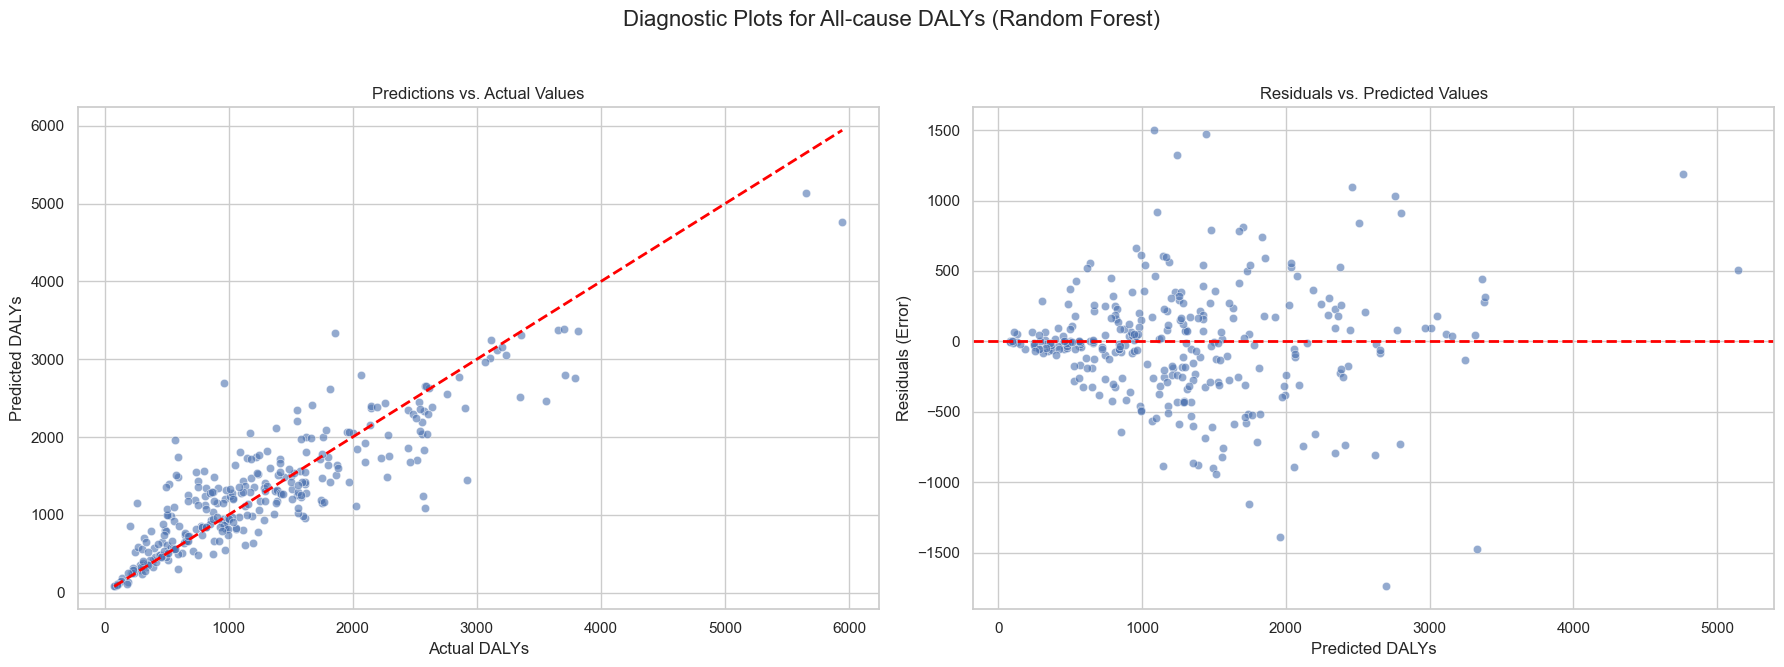

Processing diagnostics for: Cardiovascular DALYs


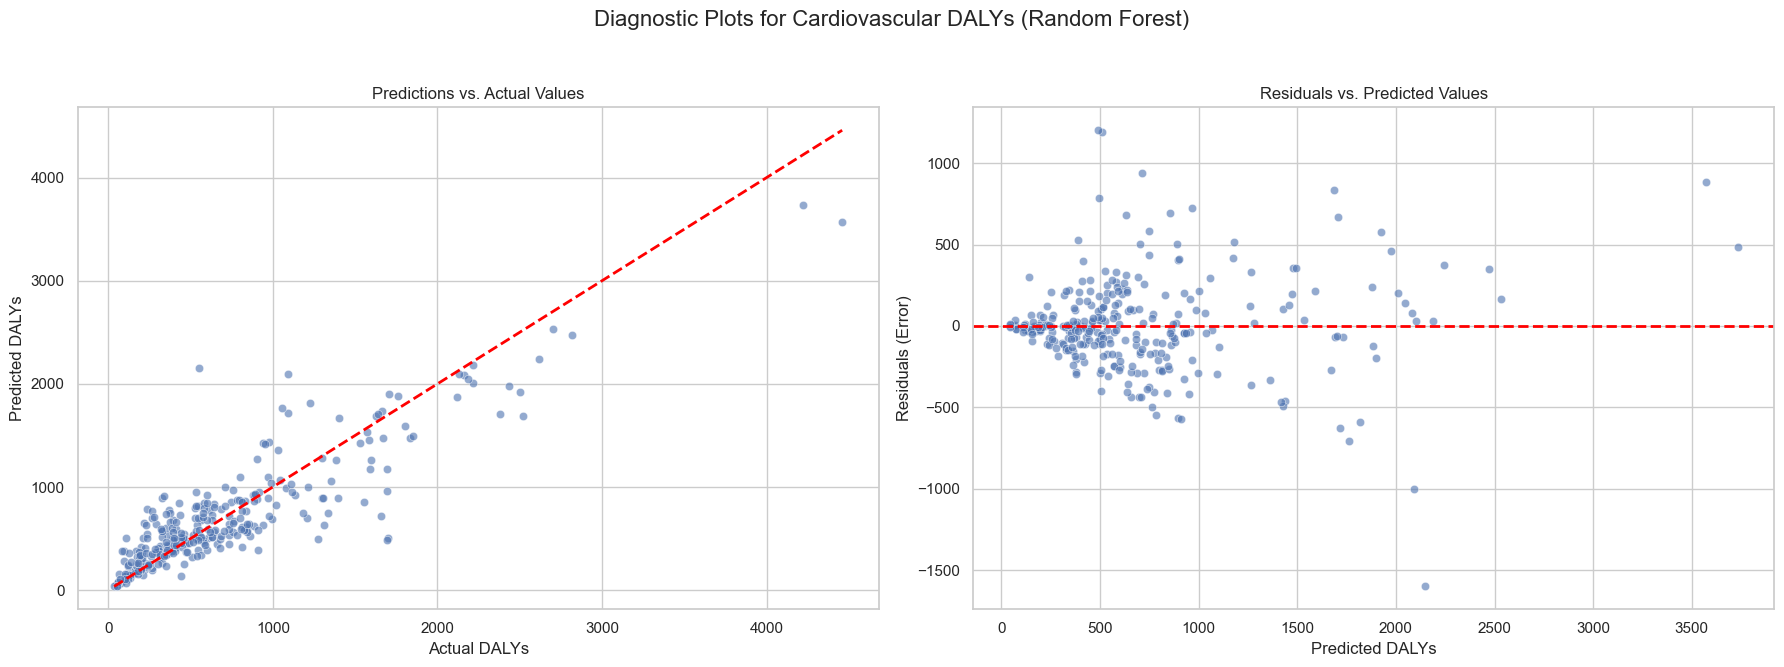

Processing diagnostics for: Stroke DALYs


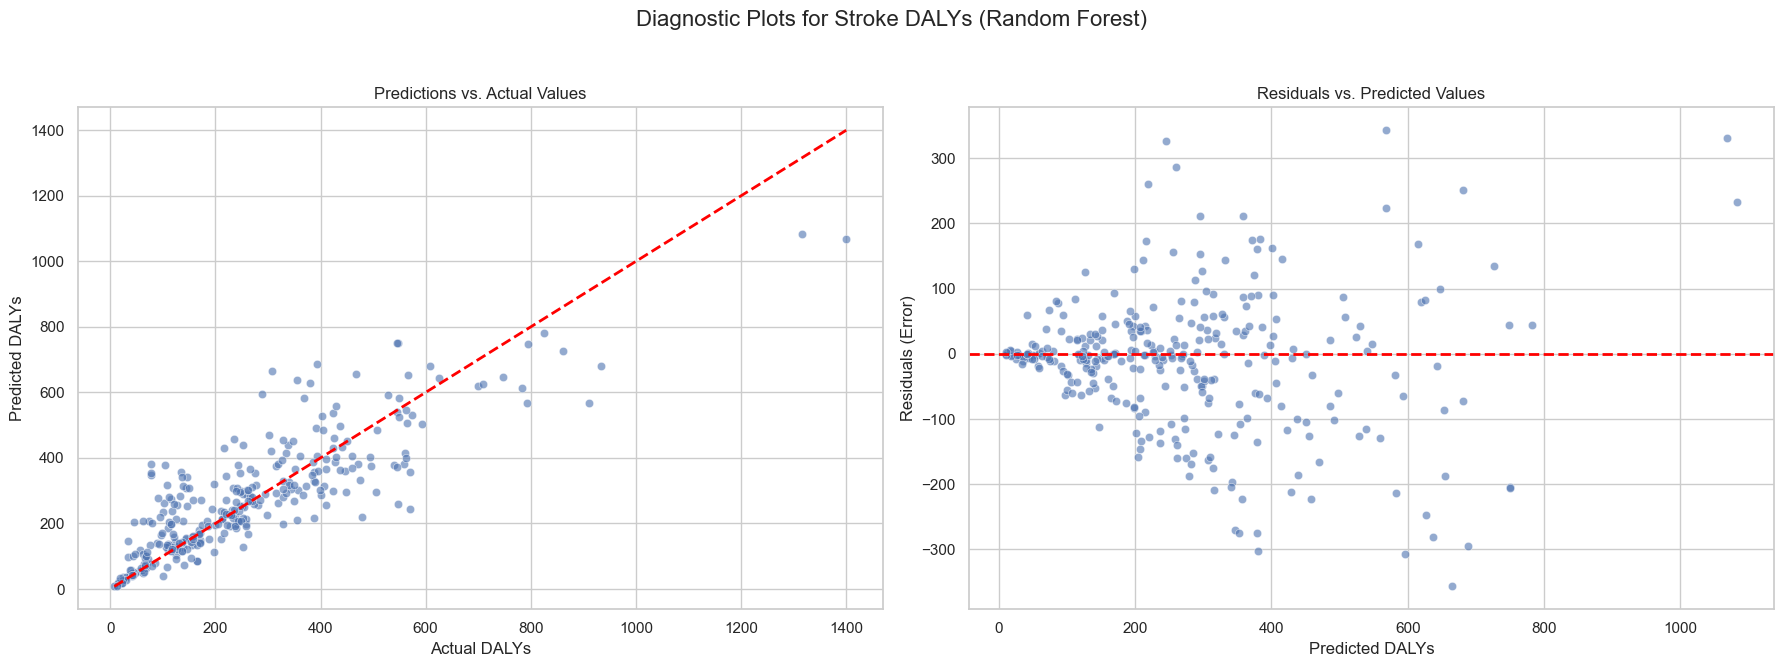

Processing diagnostics for: Respiratory DALYs


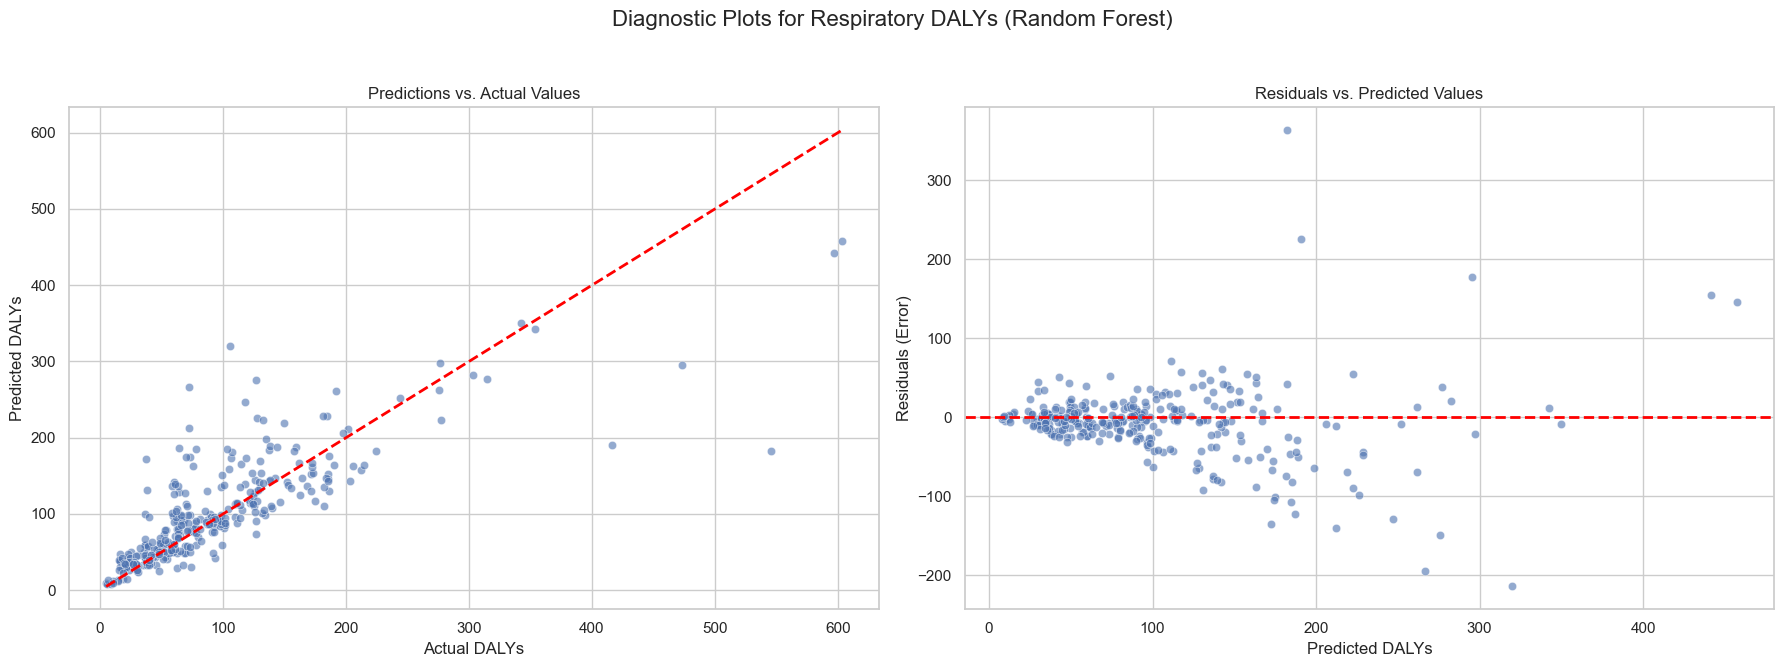

In [18]:
# Visualize model performance for the better model (Random Forest)
print("\n--- Generating Diagnostic Plots for Random Forest Models ---")

for target_name, models in trained_models.items():
    print(f"Processing diagnostics for: {target_name}")

    # Select the RF model and corresponding data
    rf_model = models["Random Forest"]
    # Regenerate test split to ensure correct data alignment
    _, X_test, _, y_test = train_test_split(
        X, y_dict[target_name], test_size=0.2, random_state=42
    )
    y_pred = rf_model.predict(X_test)
    residuals = y_test - y_pred

    # Create subplot for diagnostics
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle(f"Diagnostic Plots for {target_name} (Random Forest)", fontsize=16)

    # 1. Predictions vs. Actual Plot
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=axes[0])
    axes[0].plot(
        [y_test.min(), y_test.max()],
        [y_test.min(), y_test.max()],
        "--",
        color="red",
        lw=2,
    )
    axes[0].set_title("Predictions vs. Actual Values")
    axes[0].set_xlabel("Actual DALYs")
    axes[0].set_ylabel("Predicted DALYs")

    # 2. Residuals vs. Predicted Plot
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=axes[1])
    axes[1].axhline(0, linestyle="--", color="red", lw=2)
    axes[1].set_title("Residuals vs. Predicted Values")
    axes[1].set_xlabel("Predicted DALYs")
    axes[1].set_ylabel("Residuals (Error)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(figure_dir / f"diag_plots_{target_name.replace(' ', '_').lower()}.png")
    plt.show()